# Unit 7: Calculating trends in cooling degree days 


Cooling degree days (CDD) are used to study regional climates in connection with energy consumption for air conditioning (and other heat-related energy production/consumption processes). 

<img src="map_us_cdd.png" width=600 height=400>




## 1. Testing the null hypothesis: There are **no** significant trends in the CDD values!

We have four stations from the US that we want to analyze.

* Albany 
* NY City
* Fresno
* Seattle

The notebook shows sufficient code for the analysis of one station. It can easily be applied to the other stations.

In [85]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt # handles dates for us
import pandas as pd
# For the linear regression we use Scipy's function linregress()
from scipy.stats import linregress


# slightly better plots we can get when we
# load the package that changes the default plotting of matplotlib
import seaborn as sns
sns.set_theme()

###############################################################
# local modules: 
# Make sure you have acis.py in the same folder 
# together with this notebook!!!
###############################################################
import acis as ac # download and load functions for daily data

In this script we use the module acis again. This allows us to access the GHCN-daily station data from the server in Cornell.

We need the following functions from this module:

* *ac.download_stationdata_dly_years*
* *ac.load_station_data_dly*


In [86]:
#################################################
# Control variables 
#################################################
# first and last year to download
yr1, yr2 = 1950 , 2018

d1=dt.datetime(yr1,1,1)
d2=dt.datetime(yr2,12,31)
# datetime objects can calculate the number of days for us
# We need ndays to create the correct 2-dimensional data array for tmax below
diff=d2-d1
ndays=diff.days+1

print(f"Excepted number of days (rows ) in the dowloaded CSV files: {ndays}")

###########################################################
# The new way with a dictionary named stationlist
###########################################################
stations={'USW00014735':'Albany AP',
          'USW00094728':'New York CNTRL PK TWR',
          'USW00024233':'Seattle_Tacoma_Intl_AP',
          'USW00093193':'Fresno_Yosemite_Intl_AP'}




Excepted number of days (rows ) in the dowloaded CSV files: 25202


### Accessing the data server and saving the four station data as local CSV files



In [87]:
for key in stations:# key is the station id e.g. USW00014735
    print ("Get data for station "+stations[key])
    filename=key+"_"+str(yr1)+"-"+str(yr2)+"_dly.csv"
    print ("download data to local file "+filename)
    result=ac.download_stationdata_dly_years(key,startyear=yr1,endyear=yr2)


Get data for station Albany AP
download data to local file USW00014735_1950-2018_dly.csv
################################################################################
# send data request to http://data.rcc-acis.org/StnData
################################################################################
saved data to local file USW00014735_1950-2018_dly.csv
data columns are:
0 : date
1 : min_temp
2 : mean_temp
3 : max_temp
4 : pcpn
5 : snow
Get data for station New York CNTRL PK TWR
download data to local file USW00094728_1950-2018_dly.csv
################################################################################
# send data request to http://data.rcc-acis.org/StnData
################################################################################
saved data to local file USW00094728_1950-2018_dly.csv
data columns are:
0 : date
1 : min_temp
2 : mean_temp
3 : max_temp
4 : pcpn
5 : snow
Get data for station Seattle_Tacoma_Intl_AP
download data to local file USW00024233_1950-2018_

### Reading the local CSV spreadsheet files 

 

In [95]:
# first four lines have text info, use keyword argument skiprows
# label and station are used later for figure titles
# and in print statements


label, station ='USW00014735', 'Albany NY'

#label, station ='USW00094728', 'New York CNTRL PK TWR',

#label,station = 'USW00024233', 'Seattle_Tacoma_Intl_AP'

#label,station = 'USW00093193', 'Fresno_Yosemite_Intl_AP'

station=stations[label]
print ("selected station key (label) "+label+" station name: "+station)

filename=f"{label}_1950-2018_dly.csv"
print("load data file "+filename)
df=ac.load_station_data_dly(filename) 

df
#NOTE pcpn and snow can contain missing values or flags for trace of precpipitation 
# you can check with 
#df.query("pcpn =='T' or pcpn == 'M'") 


selected station key (label) USW00014735 station name: Albany AP
load data file USW00014735_1950-2018_dly.csv
number of data rows: 25202
returns the 2-d arrays with columns
0 year
1 month
2 day
3 min_temp
4 mean_temp
5 max_temp
6 pcpn
7 snow


,year,month,day,min_temp,mean_temp,max_temp,pcpn,snow
time,,,,,,,,
1950-01-01,1950,1,1,22.0,29.5,37.0,0.000000e+00,0.0
1950-01-02,1950,1,2,32.0,35.5,39.0,6.000000e-02,0.0
1950-01-03,1950,1,3,38.0,46.5,55.0,1.000000e-02,0.0
1950-01-04,1950,1,4,55.0,59.5,64.0,1.000000e-09,0.0
1950-01-05,1950,1,5,35.0,49.5,64.0,9.000000e-02,0.0
...,...,...,...,...,...,...,...,...
2018-12-27,2018,12,27,24.0,29.5,35.0,0.000000e+00,0.0
2018-12-28,2018,12,28,35.0,42.5,50.0,9.000000e-02,0.0
2018-12-29,2018,12,29,26.0,38.0,50.0,0.000000e+00,0.0


### Calculate total cooling degree days for each year in a range of years

Now let's calculate the total CDDs per year for a range of years for each station. 
- First, define the range of years of interest. 
- Second, develop code that extracts one year of data from the dataframe.
- Then, develop a loop that allows to repeat the CDD calculation for each year.
- Lastly, plot the CDD time series over the years. 


Note: For stations with incomplete data, there is could be a _RunTimeWarning_ showing up while running this code. It appears that when calculating the CDDs by subtracting 65.0 from the mean temperature data (This could be due to how Python handles the nan value(s) in the dataframe. within the mean temperature array. However, everything still appears to produce correct results. (worth to double-check - but that we defer to another course)

### Calculation of Cooling Degree Days for one selected station and for one year

This version of the notebook makes use of Pandas DataFrames. We use the query method to select 
rows that belong to the year 2018, as an example. Let's first take a look atthe daily mean temperatures.


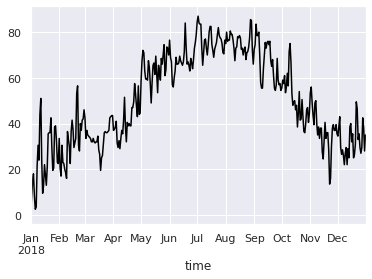

In [96]:
dfq=df.query("year == 2018")


# The Pandas DataFrame method for plotting
dfq['mean_temp'].plot(color='black')

# or the standard matplotlib method

#plt.plot(dfq['mean_temp'],color='black')

plt.show()


### Calculation of Cooling Degree Days using numpy methods

- check where in the 'array' mean_temp the values are > 65F
- then sum up the temperature values increments above 65 F for all days


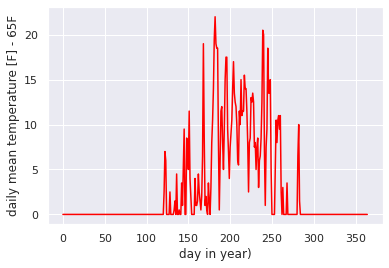

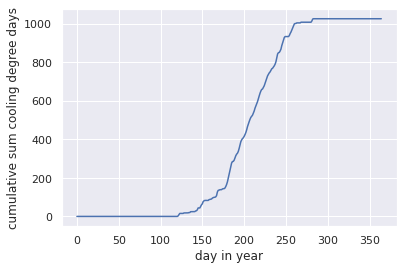

CDD for the selected station:  USW00014735
The CDD for the selected year is 1026.0 F 


In [97]:

tbase=65

# get data from dataframe into a numpy array
mean_temp=dfq['mean_temp'].values 
tempadd=np.where(mean_temp>tbase,mean_temp-tbase,0) 
plt.plot(tempadd,color='red')
plt.xlabel("day in year)")
plt.ylabel("daily mean temperature [F] - 65F")
plt.show()

plt.plot(np.cumsum(tempadd))
plt.xlabel("day in year")
plt.ylabel("cumulative sum cooling degree days")
plt.show()
print ("CDD for the selected station: ",label)
print (f"The CDD for the selected year is {np.sum(tempadd)} F ")



### Pandas method for calculation of the CDD



In [98]:
tbase=65
# dfq is already selected to be one year of data, only
dfq65=dfq.query(f"mean_temp > {tbase}")
tempadd=dfq65['mean_temp'].values-tbase
cdd=np.sum(tempadd)
print (f"The CDD for the selected year is {cdd} F ")

# or you could do this
# cdd=(dfq65['mean_temp'].values-tbase).sum()


The CDD for the selected year is 1026.0 F 


## Here we begin the analysis of the temporal variability in CDDs

### First, let's calculate CDD values for each year 1950-2018

In [99]:
yr1 = 1950
yr2 = 2018
tbase=65 # base temperature for CDD calculations
years = np.arange(yr1,yr2+1,1)

cdd_list = [] 
for i,yr in enumerate(years):
    dfq=df.query(f"year == {yr}")
    # dfq is already selected to be one year of data, only
    dfq65=dfq.query(f"mean_temp > {tbase}")
    tempadd=dfq65['mean_temp'].values-tbase
    cdd=np.sum(tempadd)
    cdd_list.append(cdd)
cdds=np.array(cdd_list)

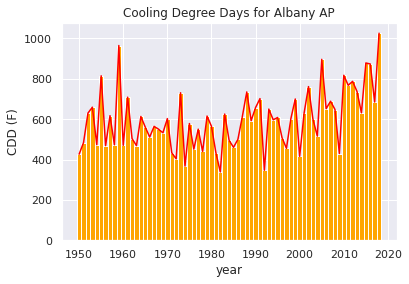

In [100]:
# first plot of the time series (without trend line)
plt.bar(years,cdds,color='orange',width=1)
plt.plot(years,cdds,color='red')
plt.xlabel("year")
plt.ylabel("CDD (F)")
plt.title("Cooling Degree Days for "+station)

plt.show()

## Here comes the statistical part 
## Linear regression

### Trend analysis 1950-2018 

In [101]:
# linear regression line
yr1 = 1950
yr2 = 2018
tbase=65 # base temperature for CDD calculations
years = np.arange(yr1,yr2+1,1)
cdd_list = [] 
for i,yr in enumerate(years):
    dfq=df.query(f"year == {yr}")
    # dfq is already selected to be one year of data, only
    dfq65=dfq.query(f"mean_temp > {tbase}")
    tempadd=dfq65['mean_temp'].values-tbase
    result=np.sum(tempadd)
    cdd_list.append(result)
cdds=np.array(cdd_list)

x=years
y=cdds

b, a, r, p_value,dump =linregress(x,y)
print(f"The linear regression line for {yr1}-{yr2}:")
print(f"yfit={a:.2f}+{b:.2f}*x")
print(f"with correlation r={r:.2f}")
print(f"and p-value to H0: 'b equal 0' is p={p_value:.5f}")

# fitted values (they lie on the trend line)
cdds1=cdds # save for plotting
years1=years # save for plotting 
cdd_trend1=a+b*years1

The linear regression line for 1950-2018:
yfit=-5155.11+2.90*x
with correlation r=0.39
and p-value to H0: 'b equal 0' is p=0.00081


## Trend analysis 1980-2018


In [102]:
# linear regression line
# one has several options how to use copy and paste
# of code from above
# just make sure that you have new variable names 
# to store the results so that we can compare the 
# trend line with the previous trend line
yr1 = 1980
yr2 = 2018
tbase=65 # base temperature for CDD calculations
years = np.arange(yr1,yr2+1,1)
cdd_list = [] 
for i,yr in enumerate(years):
    dfq=df.query(f"year == {yr}")
    # dfq is already selected to be one year of data, only
    dfq65=dfq.query(f"mean_temp > {tbase}")
    tempadd=dfq65['mean_temp'].values-tbase
    result=np.sum(tempadd)
    cdd_list.append(result)

cdds=np.array(cdd_list)

x=years
y=cdds

b, a, r, p_value,dump =linregress(x,y)
print(f"The linear regression line for {yr1}-{yr2}:")
print(f"yfit={a:.2f}+{b:.2f}*x")
print(f"with correlation r={r:.2f}")
print(f"and p-value to H0: 'b equal 0' is p={p_value:.5f}")
years2=years # save for plotting
cdds2=cdds # sav for plotting
cdd_trend2=a+b*years2

The linear regression line for 1980-2018:
yfit=-16001.56+8.32*x
with correlation r=0.61
and p-value to H0: 'b equal 0' is p=0.00003


## Show the fitted regression line in the plot


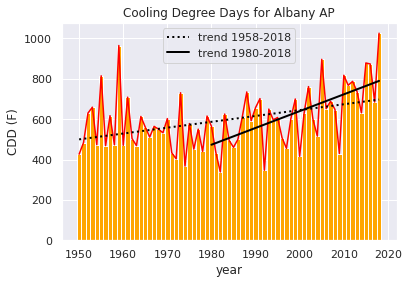

In [103]:


plt.bar(years1,cdds1,color='orange',width=1)
plt.plot(years1,cdds1,color='red')
plt.plot(years1,cdd_trend1,':',color='black',linewidth=2,label='trend 1958-2018')
plt.plot(years2,cdd_trend2,'-',color='black',linewidth=2,label='trend 1980-2018')
plt.xlabel("year")
plt.ylabel("CDD (F)")
plt.title("Cooling Degree Days for "+station)
plt.legend()

plt.show()


### References

Cooling degree days:
    
    
* Definition of cooling degree days (CDD) with base 65F:
    * [see the National Weather Service](https://www.weather.gov/key/climate_heat_cool)
* What are cooling degree days and how can we use them as indices for climate change?
    * [see EPA](https://www.epa.gov/climate-indicators/climate-change-indicators-heating-and-cooling-degree-days)
* Global Historical Climate Network - Daliy FTP site: [GHCNd](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily) 
